In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as snd
import scipy.io as sci
import scipy
from HW4Functions import myNMF
from sklearn.decomposition import NMF

In [85]:

# Training Speech dictionary
x, sr = librosa.load("sounds.wav", sr=None) # Loading in audio file

# Calculating the spectrogram of the audio file
S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 3
nIter = 350

[W_Speech,H,KL] = myNMF(S_mag,r,nIter)

Y_Speech = np.dot(W_Speech,H) # Reconstructed Spectrogram

In [86]:

x, sr = librosa.load("beatboxtest.wav", sr=None) # Loading in audio file

# Calculating the spectrogram of the audio file
S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 3
nIter = 100
# [m,n] = S_mag.shape
# H = np.random.rand(r,n)
# H = H.astype('float32')
# W_Speech = W_Speech.astype('float32')

# model = NMF(n_components=r, init='custom', max_iter=500);
# W_Combo = model.fit_transform(S_mag, H=H, W=W_Speech)
# H = model.components_

[W_Combo,H,KL] = myNMF(S_mag,r,nIter,bUpdateW=0,initW=W_Speech)
# W, H = librosa.decompose.decompose(S_mag, n_components=r, sort=True, init='custom', W= W_Speech, H =H)

Text(0, 0.5, 'Frequency (Hz)')

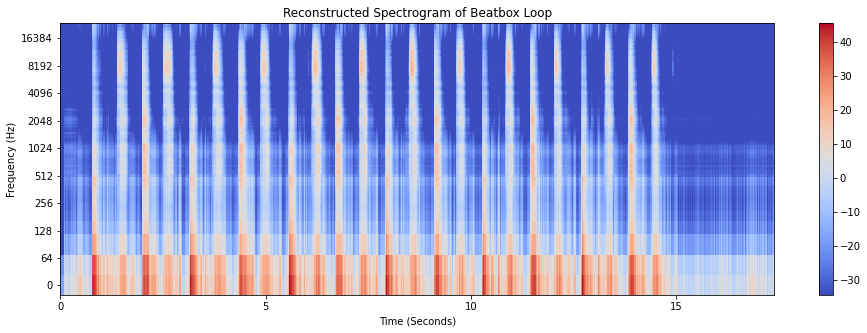

In [87]:
Y_beatbox = np.dot(W_Combo,H) # Reconstructed Spectrogram
y_beatbox = librosa.istft(Y_beatbox * S_phase, length = len(x) - 500, hop_length=256, win_length= 2048, n_fft=2048) # Inverse STFT 

plt.figure(figsize=(16, 5))
Y_db = librosa.amplitude_to_db(Y_beatbox)
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Reconstructed Spectrogram of Beatbox Loop")
plt.xlabel("Time (Seconds)")
plt.ylabel("Frequency (Hz)")



# Saving separated reconstructions

# snd.write('noise_sep.wav',y_SepNoise,sr,subtype='PCM_16')

In [88]:
for n in range(r):
    
    # Re-create the STFT of a single NMF component.
    Y = np.outer(W_Combo[:,n], H[n])*S_phase
    
    # Transform the STFT into the time domain.
    y = librosa.istft(Y)
    
    print('Component {}:'.format(n))
    display(Audio(data=y, rate=sr))

Component 0:


Component 1:


Component 2:


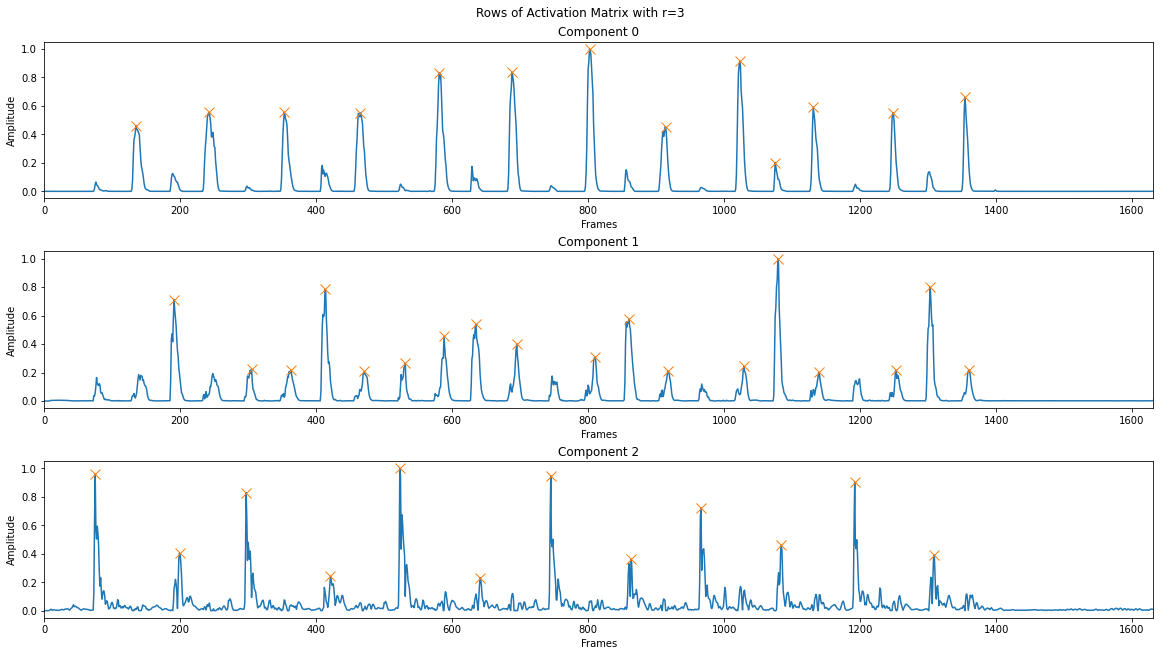

In [89]:
 # Scaling the activation matrix
# Plotting the activation matrix
fig, ax = plt.subplots(3,1,constrained_layout=True, figsize=(16,9))
fig.suptitle("Rows of Activation Matrix with r=3")
axes = ax.flat
localmax = np.zeros((3,100), dtype= int)
numMax = [0,0,0]


for n in range(r):

    H[n,:] *= 1.0 / (H[n,:].max())
    maxima, _ = scipy.signal.find_peaks(H[n,:], height=0.2, distance=18)
    localmax[n, 0:len(maxima)] = maxima
    axes[n].plot(H[n,:])
    axes[n].plot(maxima, H[n,maxima],'x',ms=10)
    axes[n].set_xlim(0, H.shape[1])
    axes[n].set_title('Component %d' % n)
    axes[n].set_xlabel('Frames')
    axes[n].set_ylabel('Amplitude')
    numMax[n] = len(maxima)



In [90]:
maximas = np.concatenate([localmax[0],localmax[1],localmax[2]])
maximas = maximas[maximas != 0]
maximas = np.sort(maximas)

In [91]:
for i in range(0,len(maximas)-1):
    if(maximas[i+1] <= maximas[i] + 10):
        idx1 = np.where(localmax == maximas[i])[0][0]
        idx2 = np.where(localmax == maximas[i+1])[0][0]

        if(H[idx1,maximas[i]] > H[idx2,maximas[i+1]]):
            localmax[idx2, np.where(localmax[idx2] == maximas[i+1])[0]] = 0
        else:
            localmax[idx1,np.where(localmax[idx1] == maximas[i])[0]] = 0

        

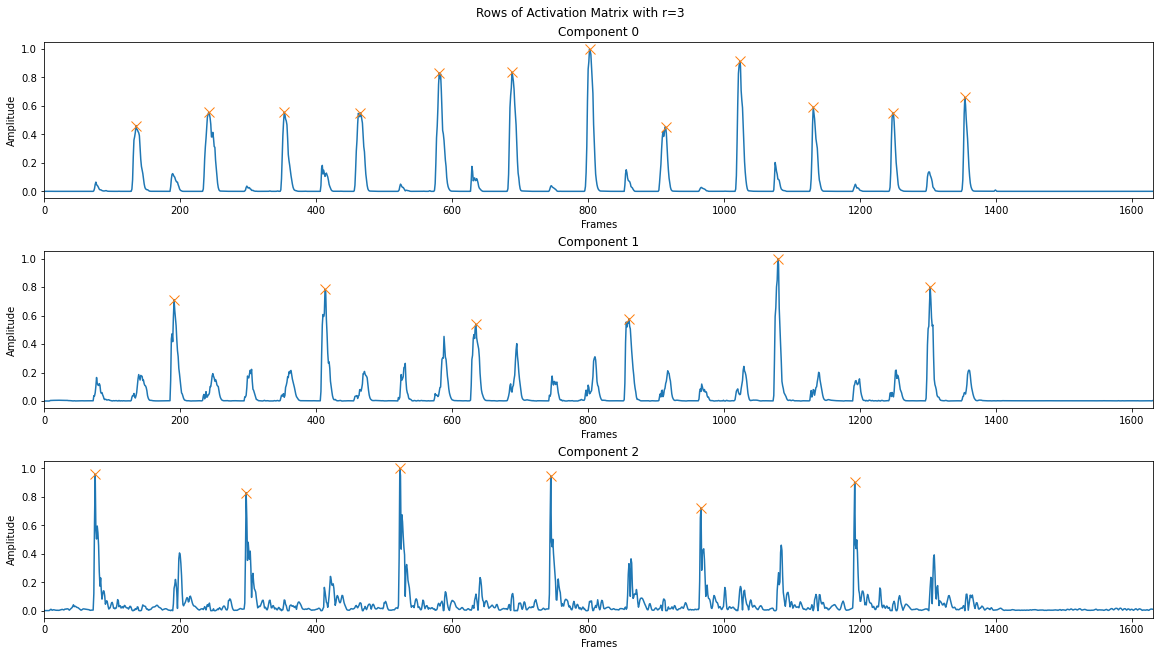

In [92]:
fig, ax = plt.subplots(3,1,constrained_layout=True, figsize=(16,9))
fig.suptitle("Rows of Activation Matrix with r=3")
axes = ax.flat

numframes = np.floor(x.size/256).astype(int)

triggers = np.zeros((3,numframes),dtype=int)
temps = np.zeros((3,100), dtype= int)
triggers_upsampled = np.zeros((3,numframes*2 - 1), dtype=int)

for n in range(r):
    max = localmax[n][localmax[n] != 0]
    temps[n, 0:len(max)] = max
    H[n,:] *= 1.0 / (H[n,:].max())
    
    axes[n].plot(H[n,:])
    axes[n].plot(max,H[n,max],'x',ms=10)
    axes[n].set_xlim(0, H.shape[1])
    axes[n].set_title('Component %d' % n)
    axes[n].set_xlabel('Frames')
    axes[n].set_ylabel('Amplitude')
    numMax[n] = len(maxima)

    for i in range(numframes):
        if(i in max):
            triggers[n,i] = 1
    
    



In [93]:
snare, _ = librosa.load("Fakie Flip Snare.wav", sr=None) # Loading in audio file
kick, _ = librosa.load("Nollie Kick.wav", sr=None) # Loading in audio file
hihat, _ = librosa.load("Heel Flip Hat.wav", sr=None) # Loading in audio file

In [94]:

test = np.zeros((3,len(triggers[0]) + (len(triggers[0])-1)*(255)))
for n in range(3):
    test[n][::256] = triggers[n]

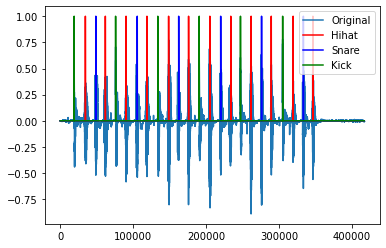

In [112]:
plt.plot(x)
plt.plot(test[0],'r')
plt.plot(test[1], 'b')
plt.plot(test[2], 'g')
plt.legend(["Original","Hihat","Snare","Kick"])

In [102]:
out = np.zeros(len(test[0])+93000)

for samp in range(len(test[0])):
    if(test[1,samp] == 1):
        out[samp:len(snare)+samp] = snare
    elif(test[2,samp] == 1):
        out[samp:len(kick)+samp] = kick
    elif(test[0,samp] == 1):
        out[samp:len(hihat)+samp] = hihat



In [58]:
triggers[:,1]

array([0, 0, 0])

In [ ]:
len(test[0])

417025

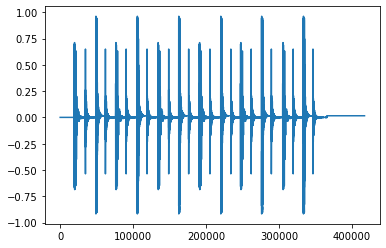

In [110]:
plt.plot(out)

In [108]:
if(x.size < out.size):
    out = out[0:len(x)]

Audio(data=out+x, rate=44100)

In [107]:
x, sr = librosa.load("beatboxtest.wav", sr=None) # Loading in audio file